Leiden followed by C means clustering of regulome

First make a proof of concept using igraph

Questions:
- How to measure distance
- How to measure membership
- How to treat small clusters - leave and expand or remove and add nodes to new?

If it works:
- make faster implementation


Problems:
- current distance measure: 
    - favors large clusters and nodes with high degree
    - maybe make measure of distance based on the number of nodes in the cluster
        - in a cluster of 10, 10 edges would make highly conncted to cluster, but in cluster of 100, 10 edges might not.
        - ideally, if node connected to all nodes, with 1 PPV - distance should be nearing 0, if no connection should be 1
        - 1 - (n_nodes_cluster/sum(distances))
            - this will favor smaller clusters

In [1]:
# Import packages

import igraph as ig
import pandas as pd
import numpy as np
import seaborn as sns
from compress_pickle import load, dump
from statistics import mean
from IPython.display import clear_output

def open_pickle(file):
    with open(path+file, 'rb') as pickle_file:
        return load(path=pickle_file, compression='infer')

path = './files/'

In [2]:
# load regulome
regulome_network_edges = pd.read_csv(filepath_or_buffer=path+'/human_regulome_pd.gz', compression='infer')
regulome_network_edges = regulome_network_edges.astype({'ProteinAid': 'str', 'ProteinBid':'str'})

regulome_graph = ig.Graph.DataFrame(regulome_network_edges, directed=False, use_vids=False)
# msigdb_c3_tft_dict = open_pickle('msigdb_c3_tft_dict.pkl')
proteins = pd.concat([regulome_network_edges['ProteinAid'], regulome_network_edges['ProteinBid']]).unique()

# del regulome_network_edges

In [3]:
def leiden_clustering(graph, res, b, n_iter):
    return graph.community_leiden(objective_function='modularity',
                            weights='PPV',
                            resolution=res,
                            beta=b,
                            n_iterations=n_iter)

leiden_clusters = leiden_clustering(regulome_graph, 4, 0.1, 10)
clusters_dict = {n:set(regulome_graph.vs[node]['name'] for node in cluster) for (n, cluster) in enumerate(leiden_clusters)}

<Axes: ylabel='Count'>

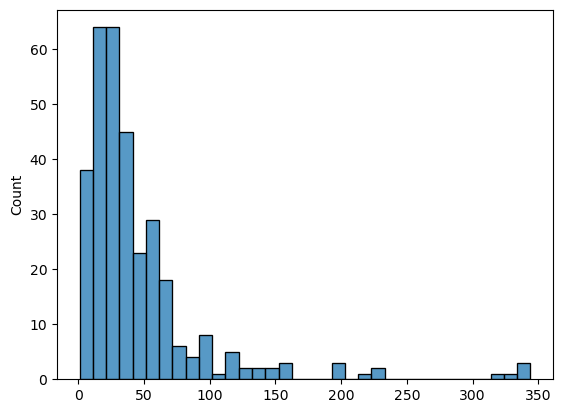

In [19]:
sns.histplot([len(cluster) for cluster in clusters_dict.values()])

AttributeError: 'Axes' object has no attribute 'savefig'

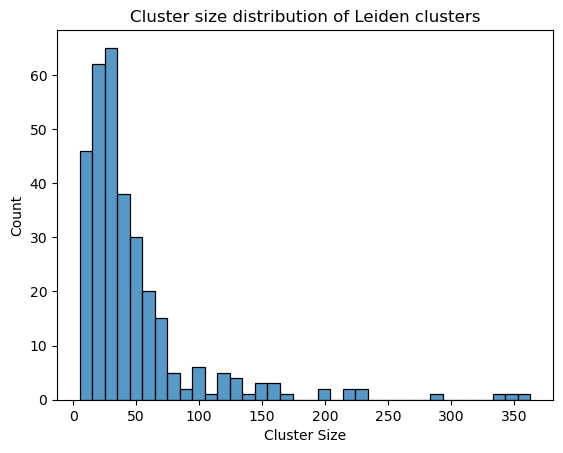

In [4]:
fig = sns.histplot(leiden_clusters.sizes())
fig.set_title("Cluster size distribution of Leiden clusters")
fig.set_xlabel("Cluster Size")
fig.savefig("./images/LiedenClustersDistr.png")

In [5]:
with open(path+'path_lengths_dict.gz', 'rb') as file:
    path_lengths_dict = load(file, compression='infer')

In [8]:
from itertools import chain
from joblib import Parallel, delayed
from copy import deepcopy

### Functions for calculating distance from node to cluster
def inverse_sum_PPV_dist(neighbors, cluster):
    std_dist = 1.5
    
    connected_nodes = cluster.intersection(set(neighbors.keys()))
    if len(connected_nodes) == 0:
        return std_dist # determine the standard distance - 1.5/min(weight) 
    
    weights_sum = sum([neighbors[node] for node in connected_nodes])
    if weights_sum == 0:
        return std_dist
    
    return 1 / weights_sum


def path_length_dist(path_lengths, cluster):    
    return mean([path_lengths[node] for node in cluster])


def node_c_distances(neighbors, clusters, distance_measure='dist_sum'): # add weight formula argument:
    node_distances = dict()

    for (cluster_id, cluster) in clusters.items():
        match distance_measure:
            case 'dist_sum':
                node_distances[cluster_id] =  inverse_sum_PPV_dist(neighbors, cluster)# set 1.5 as max distance, should I set other to more ?
            case 'path_len':
                node_distances[cluster_id] = path_length_dist(neighbors, cluster)
            case _:
                return # quit function if wrong function name
    return node_distances


### Function to calculate membership values for node
def calc_membership(node_distances, m):
    node_memberships = dict()

    for (cluster_id, d) in node_distances.items():         
        fuzzy_exponent = (1 / (m - 1))

        # give better name - denomintation or membership function  
        membership_den = [(d / other_d) ** fuzzy_exponent for other_d in node_distances.values()]
        node_memberships[cluster_id] = 1 / sum(membership_den)

    return node_memberships


### Function to calcualte node addition to objective function J (optimization function)
def optimization_function(node_distances, node_memberships, m): # change function name
    node_J = 0
    for cluster_id in node_distances.keys():
        node_J += node_memberships[cluster_id]**m * node_distances[cluster_id]**2
    return node_J
    

### Function for iteration of each node, calculates distance, membership and J
# Necessary for parallelization
def node_iteration(node, neighbors, clusters, m, optimize):
    node_distances = node_c_distances(neighbors, clusters) # returns dictionary with distance to each cluster
    node_memberships = calc_membership(node_distances, m) # adds memberships of node to dictionary
    if optimize:
        Ji = optimization_function(node_distances, node_memberships, m)
        return node, node_distances, node_memberships, Ji
    return node, node_distances, node_memberships


def gather_neighbors(graph, nodes, distance_measure='dist_sum'):
    match distance_measure:
        case 'dist_sum':
            return {
                node : {
                    graph.vs[neighbor]['name'] : graph.es[graph.get_eid(node, neighbor)]['PPV'] for neighbor in graph.neighbors(node)
                    } 
                    for node in nodes
                }
        case _:
            return 


def update_clusters_perc(memberships_dict, clusters, percentile=0.95):
    print(f"Updating Clusters: percentile {percentile}")
    for (node, memberships) in memberships_dict.items():
        perc_lim = np.percentile(list(memberships.values()), percentile)
        print(perc_lim, min(memberships.values()))
        node_clusters = [cluster_id for (cluster_id, membership) in memberships.items() if membership >= perc_lim]
        print(len(node_clusters))
        for cluster_id in node_clusters:
            clusters[cluster_id].add(node)
    return clusters


### Main function
# path_lengths only necessarz when using the path_len distance measure
def network_c_means(graph, clusters, m, optimize=False, percentile=0.95, distance_measure='dist_sum', path_lengths=None):
    # add leiden here after 
    nodes = [node['name'] for node in graph.vs]
    memberships_dict = dict()
    
    if distance_measure == 'path_len':
        if path_lengths == None:
            print("Must give dictioonary containing path lengths using path_lengths argument")
            return
        connections_dict = path_lengths # maybe change name, cuase connections_dict kinda silly
        del path_lengths
    else:
        connections_dict = gather_neighbors(graph, nodes, distance_measure)
    if optimize:
        Js = list()

    del graph

    parallel = Parallel(n_jobs=12, verbose=5, batch_size=32)
    cluster_history = [deepcopy(clusters)]

    for i in range(1,2):
        print(f'Iteration {i} of 5')

        results = parallel(delayed(node_iteration)(node, connections_dict[node], clusters, m, optimize) for node in nodes)
        Js.append(sum(result[3] for result in results)) # maybe make results into a named tuple
        
        # return {result[0] : result[2] for result in results}
        memberships_dict = {result[0] : result[2] for result in results}
        
        clusters = update_clusters_perc(memberships_dict, clusters, percentile=percentile)
        cluster_history.append(deepcopy(clusters))
        

        del results, memberships_dict
        # clear_output()
    return cluster_history, Js

In [9]:
results = network_c_means(regulome_graph, deepcopy(clusters_dict), 2, optimize=True, percentile=95, distance_measure='path_len', path_lengths=path_lengths_dict)

Iteration 1 of 5


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=12)]: Done 1560 tasks      | elapsed:   12.6s
[Parallel(n_jobs=12)]: Done 4440 tasks      | elapsed:   34.1s
[Parallel(n_jobs=12)]: Done 8472 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 13656 tasks      | elapsed:  1.7min
[Parallel(n_jobs=12)]: Done 15041 out of 15041 | elapsed:  1.8min finished


Updating Clusters: percentile 95
0.009872831874106867 0.0003037374523095159
16
0.009693126281651714 0.0002843798838270233
16
0.00988787883890491 0.0002822473625507464
16
0.009602691330011055 0.0003076934124168833
16
0.009687659919494725 0.0002857782139526229
16
0.01003685005456932 0.0002542364952624554
16
0.00965434795289899 0.0002879756859913119
16
0.009712335820157882 0.00031718446415741794
16
0.009607541545679133 0.00031643362419285563
16
0.009731578714297355 0.0002924943929271432
16
0.009588492634138555 0.00022857713425945416
16
0.009919398002453063 0.00024248495050220839
16
0.009641762727624834 0.0003214803692831025
16
0.009718859998732872 0.0002950489243422361
16
0.009699770548399751 0.00031545548426733215
16
0.009725106264243565 0.0002937520269073912
16
0.009700065419183293 0.00028738636141162116
16
0.00970221093346232 0.00031597901075395386
16
0.009631715733569758 0.00030422349126878586
16
0.009701432516242031 0.00029564823668540345
16
0.00965618943837967 0.00023882077349219919

In [37]:
proteins_counts = pd.concat([regulome_network_edges['ProteinAid'], regulome_network_edges['ProteinBid']]).value_counts()
proteins_counts

338514    7540
351021    6700
346909    6626
347524    5726
337121    5446
          ... 
331763       1
344189       1
332737       1
341734       1
335285       1
Name: count, Length: 15041, dtype: int64

0.009186796067901893
17


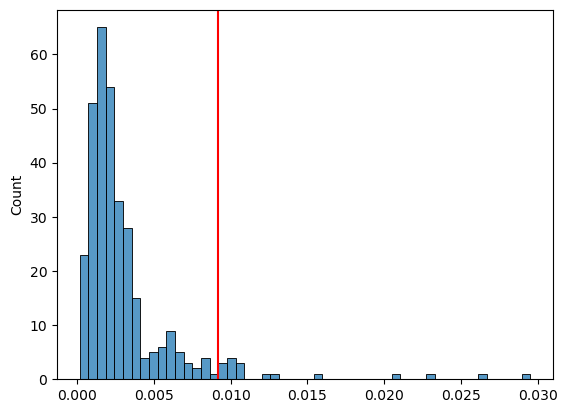

In [104]:
res = np.array([val for val in results['346909'].values()])
perc = np.percentile(res, 95)
print(perc)

print(len([cluster for (cluster, membership) in results['346909'].items() if membership >= perc]))

fig = sns.histplot(results['346909'])
fig.axvline(x=perc, c='r')

In [106]:
nodes = [node for node in regulome_graph.vs['name']]

with open(path+'path_lengths.gz', 'rb') as file:
    path_lengths = load(file, compression='infer')

path_lengths = path_lengths[0]
path_lengths_dict = dict()
n_nodes = len(nodes)
for (node_number, node) in enumerate(nodes):
    clear_output()
    print(f'{node_number}/{n_nodes}')
    path_lengths_dict[node] = {
        other_node: round(path_lengths, 2)
        for (other_node, path_lengths) in zip(nodes, path_lengths[:n_nodes])
    }
    path_lengths = path_lengths[n_nodes:]
del path_lengths

with open(path+'path_lengths_dict.gz', 'wb') as file:
    dump(path_lengths_dict,path+'path_lengths_dict.gz', compression='infer')


15040/15041


In [ ]:
from math import log10

protein_edges = pd.concat([regulome_network_edges['ProteinAid'], regulome_network_edges['ProteinBid']]).value_counts()
most_connected_proteins = tuple(protein_edges.index[:5])
least_connected_proteins = tuple(protein_edges.index[-5:])

def network_c_means_connections(graph, nodes, clusters, m, optimize=False, distance_measure='dist_sum', path_lengths=None):
    # add leiden here after 
        
    if distance_measure == 'path_len':
        if path_lengths == None:
            print("Must give dictioonary containing path lengths using path_lengths argument")
            return
        connections_dict = path_lengths # maybe change name, cuase connections_dict kinda silly
        del path_lengths
    else:
        connections_dict = gather_neighbors(graph, nodes, distance_measure)
    if optimize:
        J = 0

    results = Parallel(n_jobs=4)(delayed(node_iteration)(node, connections_dict[node], clusters, m, optimize) for node in nodes)

    memberships_dict = {result[0] : {
            cluster_id : log10(r) for (cluster_id, r) in result[2].items()
            }
        for result in results
        }
    return memberships_dict

    # distances_dict = {result[0]: tuple(r for r in result[1].values()) for result in results}
    # return distances_dict

m_values = [1.1, 2, 3, 4, 5, 6]

most_connected_memberships = dict()
for m in m_values:
    most_connected_memberships[m] = network_c_means_connections(regulome_graph, most_connected_proteins, clusters_dict, m, distance_measure='dist_sum', path_lengths=None)


least_connected_memberships = dict()
for m in m_values:
    least_connected_memberships[m] = network_c_means_connections(regulome_graph, least_connected_proteins, clusters_dict, m, distance_measure='dist_sum', path_lengths=None)

In [ ]:
# most_connected_memberships

# Manually extract the keys and values
rows = [
    (m, protein, membership)
    for (m, proteins) in most_connected_memberships.items()
    for (protein, memberships) in proteins.items()
    for membership in memberships
    if m not in [1.1] 
]

most_connected_df = pd.DataFrame(rows, columns=['fuzzy_m', 'Proteinid', 'membership'])

fig = sns.FacetGrid(most_connected_df, col='fuzzy_m', row='Proteinid')
fig.map(sns.histplot, 'membership')
fig.figure.subplots_adjust(top=0.925)
fig.set_xlabels('Membership (log10)')
fig.figure.suptitle("Membership distribution of the 5 proteins with the highest degree")
fig.refline(y=1, c='r')
# fig.savefig("./images/most_well_connected_sum_dist.png")

In [ ]:
# least_connected_memberships

# Manually extract the keys and values
rows = [
    (m, protein, membership)
    for (m, proteins) in least_connected_memberships.items()
    for (protein, memberships) in proteins.items()
    for membership in memberships
]

least_connected_df = pd.DataFrame(rows, columns=['fuzzy_m', 'Proteinid', 'membership'])

fig = sns.FacetGrid(least_connected_df, col='fuzzy_m', row='Proteinid')
fig.map(sns.histplot, 'membership')
fig.figure.subplots_adjust(top=0.925)
fig.set_xlabels('Membership (log10)')
fig.figure.suptitle("Membership distribution of the 5 proteins with the lowest degree (more than 5)")
fig.refline(y=1, c='r')

# fig.savefig("./images/least_connected_sum_dist_not1.png")

In [ ]:
from itertools import chain

def calc_dist(graph, node, clusters):
    node_distances = dict()
    neighbors = set(graph.neighbors(node))

    for (cluster_id, cluster) in clusters.items():
        connected_nodes = set(neighbors).intersection(cluster)

        if len(connected_nodes) == 0: # no need if no connections
            node_distances[cluster_id] = 1
            continue

        # get weights of each connection to nodes in the cluster
        weights = [graph.es(graph.get_eid(node, connected_node))['PPV'] for connected_node in connected_nodes]
        weights_sum = sum(chain.from_iterable(weights))

        if weights_sum == 0: # dont need this myself, but a thing to look at if want to ship out later
            node_distances[cluster_id] = 1
            continue

        node_distances[cluster_id] = 1 / weights_sum
    return node_distances


def calc_membership(node_distances, m):
    node_memberships = dict()

    for (cluster_id, d) in node_distances.items():         
        fuzzy_exponent = 2 / (m - 1)

        # give better name - denomintation or membership function  
        membership_den = [(d / other_d) ** fuzzy_exponent for other_d in node_distances.values()]

        node_memberships[cluster_id] = 1 / sum(membership_den)

    return node_memberships


def optimization_function(node_distances, node_memberships, m): # change function name
    node_J = 0
    for cluster_id in node_distances.keys():
        node_J += node_memberships[cluster_id]**m * node_distances[cluster_id]**2
    return node_J
    

def network_c_means(graph, clusters, m, optimize=False):
    # add leiden here after 

    membership_dict = dict()
    distances_dict = dict()
    
    if optimize:
        Js = list()

    for i in range(0, 10):
        for node in graph.vs:
            node = node['name']
            node_distances = calc_dist(graph, node, clusters) # returns dictionary with distance to each cluster
            node_memberships = calc_membership(node_distances, m) # adds memberships of node to dictionary

            if optimize:
                Js.append(optimization_function(node_distances, node_memberships, m))
            distances_dict[node] = node_distances # maybe just add directly to dictionary
            membership_dict[node] = node_memberships

    

    return Js

memberships = network_c_means(regulome_graph, clusters_dict, 0.5, optimize=True)